# Importing All the libraries

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn import preprocessing
from itertools import cycle
from itertools import chain
from scipy import stats

import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import math
import os
import time
from tensorflow.keras.models import load_model

from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Flatten, Dense,MaxPooling2D ,Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, LSTM
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler, LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot')
print('Keras Version', keras.__version__)

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
TIME_PERIOD = 80
WINDOW = 40
# originally used to fine tune the values, but that is now being done in a loop with several different dimension sizes.
tuner = 1

Keras Version 2.4.0


In [ ]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [ ]:
def show_basic_dataframe(dataframe):
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i' % (dataframe.shape[0]))

In [ ]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15,10), sharex=True)

    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    fig.savefig(activity+'_x-y-z-axis')
    plt.show()

In [ ]:
def plot_axis(ax,x,y,title):
    ax.plot(x,y,'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y)-np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

# Reading all accelarotmeter data of phone from the directory and saving it to one dataframe

In [ ]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp','x-axis','y-axis','z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)

    df['z-axis'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    df['z-axis'] = df['z-axis'].apply(convert_to_float)

    df.dropna(axis=0,how='any',inplace=True)
    return df


In [ ]:
def read_dir(dir_path):
    df = []
    for f_name in os.listdir(dir_path):
        if f_name.endswith('.txt'):
            df1= read_data(dir_path+f_name)
            df.append(df1)

    return df

In [ ]:
# df_full = read_dir("D:\\Courses\\AI-wearable\\Assignment 1\\wisdm-dataset\\wisdm-dataset\\raw\\phone\\accel\\")

In [ ]:
# #df= pd.concat(df_full)
# print(df.head())
# df.shape

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


Number of columns in the dataframe: 7
Number of rows in the dataframe: 4804403
    Unnamed: 0  user-id activity        timestamp  x-axis  y-axis  z-axis
0            0     1600  walking  252207666810782    -0.4     8.8     1.1
1            1     1600  walking  252207717164786    -0.9     9.8     1.0
2            2     1600  walking  252207767518790     2.0    11.1     2.6
3            3     1600  walking  252207817872794     0.5    12.7     0.2
4            4     1600  walking  252207868226798    -2.2    13.9    -4.4
5            5     1600  walking  252207918580802    -4.3    13.4    -0.7
6            6     1600  walking  252207968934806    -0.3    13.3    -0.2
7            7     1600  walking  252208019288809     1.6     9.5    -0.0
8            8     1600  walking  252208069642813    -0.3     5.3     0.3
9            9     1600  walking  252208119996817    -1.8     3.7     1.4
10          10     1600  walking  252208170350821    -1.1     4.5     2.3
11          11     1600  walking 

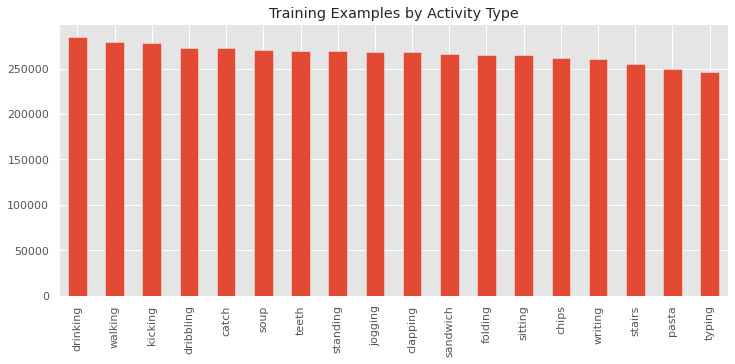

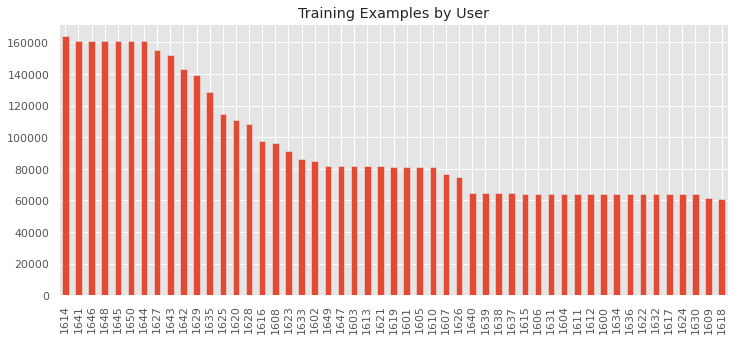

In [ ]:
#df.to_csv('full_dataset_with_18_act.csv')
df = pd.read_csv('drive/My Drive/Data/full_dataset_with_18_act.csv')

# Replacing Activity Symbols to its name.
activity_sym = ['A','B','C','D','E','F','G','H','I','J','K','L','M','O','P','Q','R','S']
activity_name = ['walking','jogging','stairs','sitting','standing','typing','teeth','soup','chips','pasta','drinking','sandwich','kicking','catch','dribbling','writing','clapping','folding']
for x,y in zip(activity_sym,activity_name):
  df = df.replace(to_replace = [x], value = y)

show_basic_dataframe(df)
print(df.head(20))
fig = plt.figure(figsize=(12,5))

df['activity'].value_counts().plot(kind='bar', title='Training Examples by Activity Type')
plt.show()
fig = plt.figure(figsize=(12,5))
fig.savefig('trainingexamplebyacitivty.png')
df['user-id'].value_counts().plot(kind='bar',title='Training Examples by User')

plt.show()
fig.savefig('trainingexamplesbyusers.png')

# Label Encoding and Segmenting

In [ ]:
def labelenocoder(df_label):
    for activity in np.unique(df_label['activity']):
        subset = df_label[df_label['activity'] == activity][:180]
        plot_activity(activity,subset)

    LABEL = 'ActivityEncoded'
    le = preprocessing.LabelEncoder()

    df_label[LABEL] = le.fit_transform(df_label['activity'].values.ravel())
    return le

In [ ]:
def create_segments_and_labels(df, time_steps, step, label_names):
    FEATURES = 3

    segments = []
    labels = []

    for i in range(0,len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        label = stats.mode(df[label_names][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

# Spliting Dataset and Model Design

In [ ]:
def spliting_dataset(df_base):
    df_test = df_base[df_base['user-id'] > 1617 ]
    df_train = df_base[df_base['user-id'] <= 1617 ]
    df_train = df_base

    pd.options.mode.chained_assignment = None
    df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
    df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
    df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

    df_train = df_train.round({'x-axis': 4, 'y-axis':4, 'z-axis': 4})

    X_train, y_train = create_segments_and_labels(df_train, TIME_PERIOD, WINDOW, LABEL)

    print('X_train Shape:', X_train.shape)
    print(X_train.shape[0], 'training samples')
    print('y_train shape: ', y_train.shape)
    input_shape = (80*3)
    x_train = X_train.reshape(X_train.shape[0], input_shape)
    # print('x_train shape:', x_train)
    print('input_shape:', input_shape)
    samps, secs, accel = X_train.shape
    red_dim = secs * accel
    
    return X_train,y_train
    

In [ ]:
def fit_model(X_train, y_train, X_val, y_val,epochs =50,learning_rate=0.001):
    # define model
    model = Sequential()
    model.add(Conv2D(64, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
    # model1.add(MaxPooling2D(pool_size=(2,2),strides=(1, 1),padding='valid'))

    model.add(Dropout(0.1))

    model.add(Conv2D(128, (2, 2), activation='relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))


    model.add(Dense(9, activation='softmax'))
    # compile model
    model.compile(optimizer=Adam(learning_rate = learning_rate,decay = 1e-6), loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
    import time
    start = time.time()
    # fit model
    history = model.fit(X_train, y_train, epochs = 50, validation_data= (X_val, y_val), verbose=1)
    stop = time.time()
    duration = stop - start
    return model,history,duration

# Evaluating model by training full

In [ ]:
def eval_standalone_model(X_train, X_test, y_train, y_test, X_val, y_val , n_repeats):
    scores = list()
    times = list()
    for _ in range(n_repeats):
        # define and fit a new model on the train dataset
        start = time.time()
        model,history,duration = fit_model(X_train, y_train,X_val, y_val)
        # evaluate model on test dataset
        stop = time.time()
        _, test_acc = model.evaluate(X_test, y_test, verbose=0)
        scores.append(test_acc)
        times.append(stop-start)
    return scores,times

# Evaluating model according to layers want to fixed

In [ ]:
def eval_transfer_model(X_train, X_test, y_train, y_test, n_fixed, n_repeats):
    scores = list()
    times = list()
    for _ in range(n_repeats):
    # load model
        model = tf.keras.models.load_model('base_model_2.h5')
        # mark layer weights as fixed or not trainable
        for i in range(n_fixed):
            model.layers[i].trainable = False
        # re-compile model
        model.compile(optimizer=Adam(learning_rate = 0.001, decay = 1e-6), loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
        # fit model on train dataset
        start = time.time()
        model.fit(X_train, y_train, epochs=50, verbose=0)
        stop = time.time()
        # evaluate model on test dataset
        _, test_acc = model.evaluate( X_test, y_test, verbose=0)
        scores.append(test_acc)
        times.append(stop-start)
    return scores,times

# Base model Training 

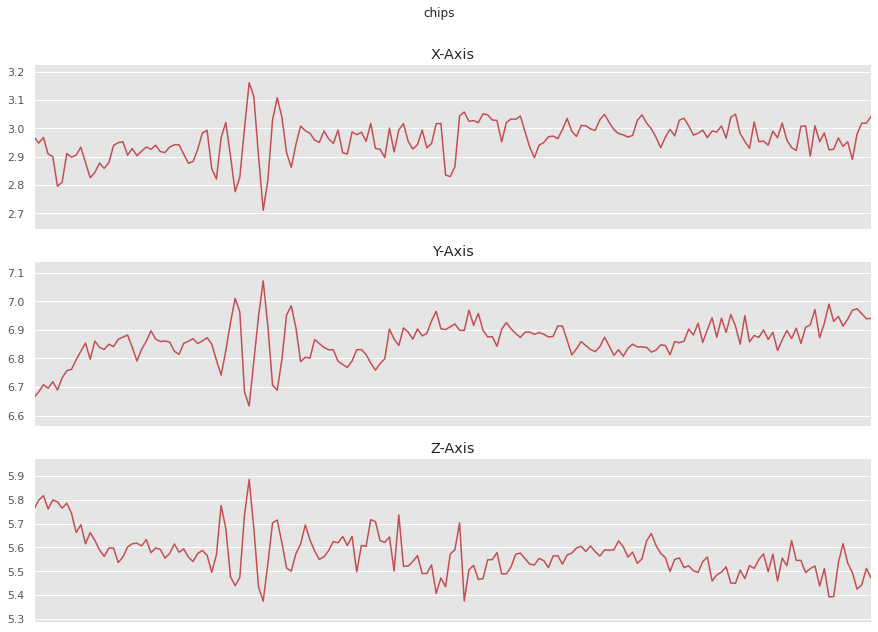

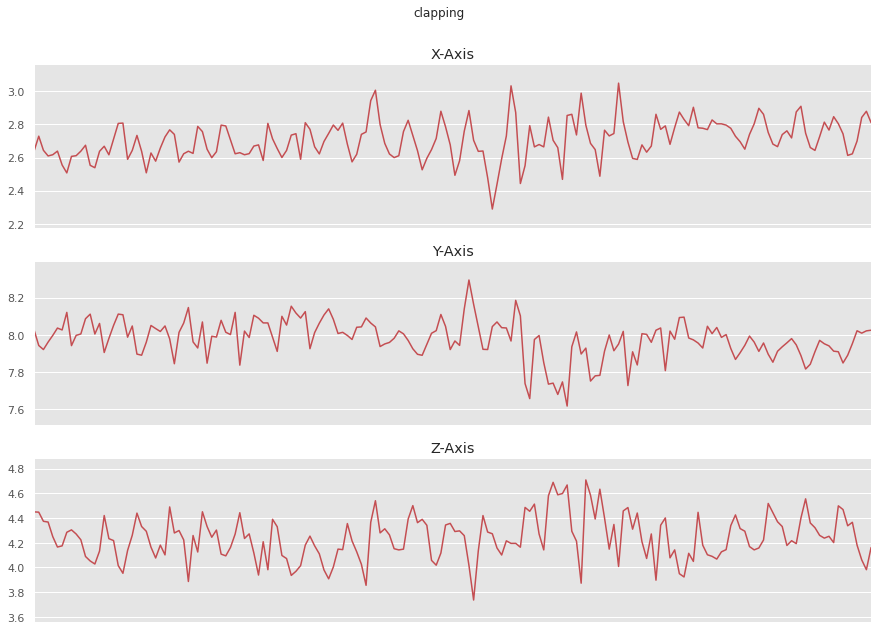

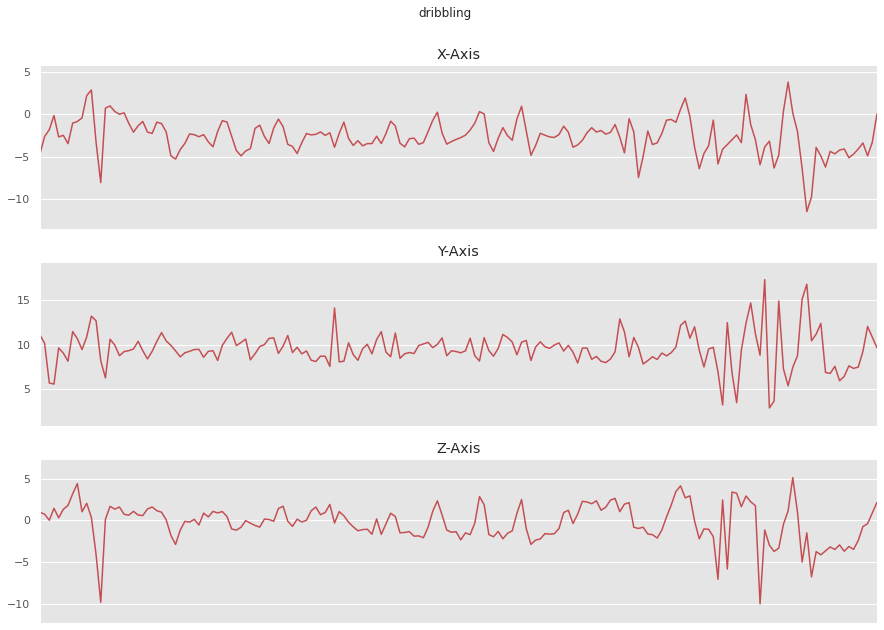

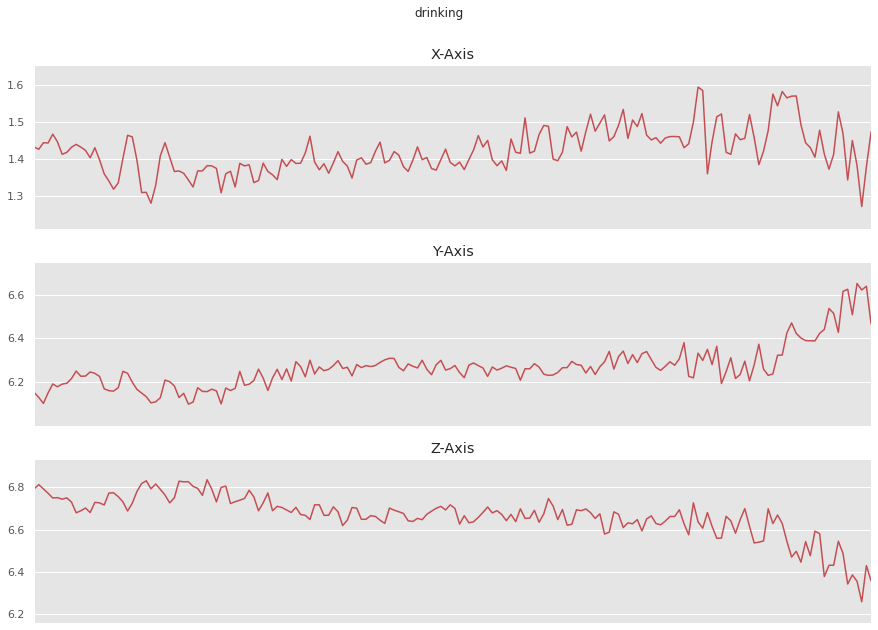

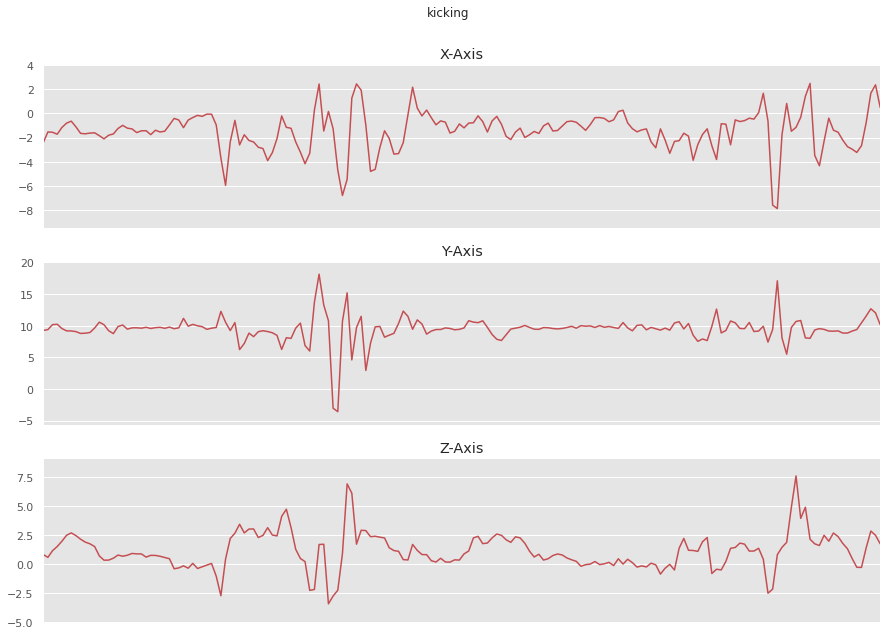

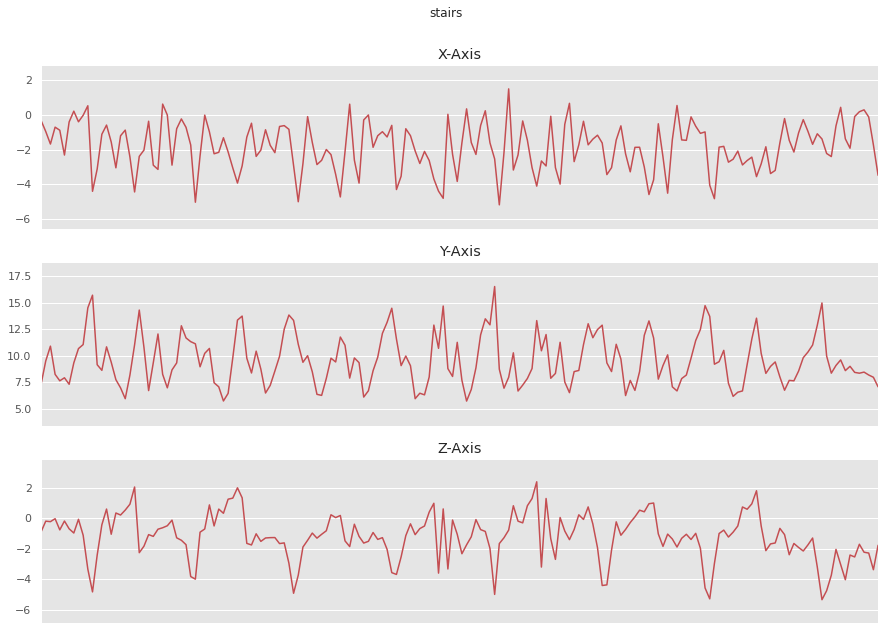

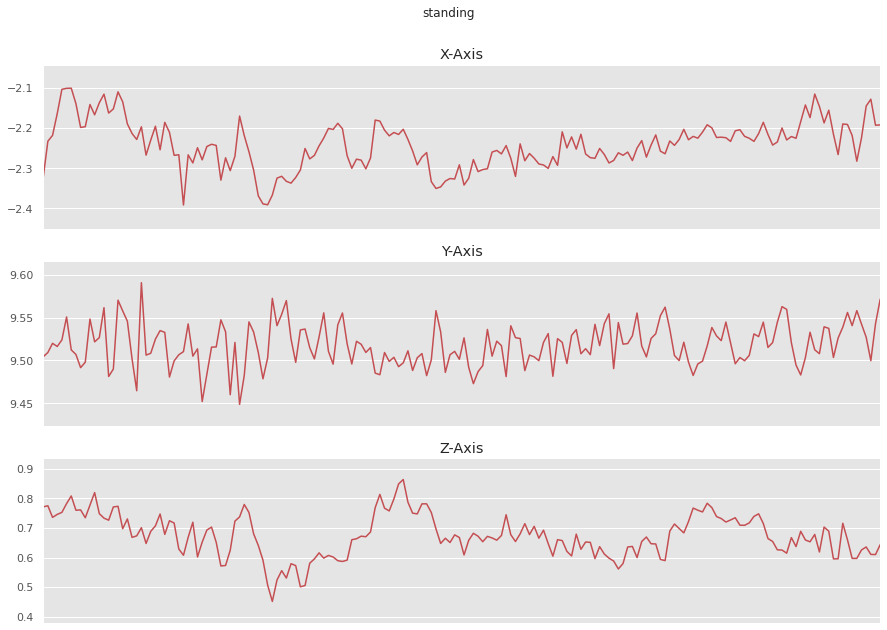

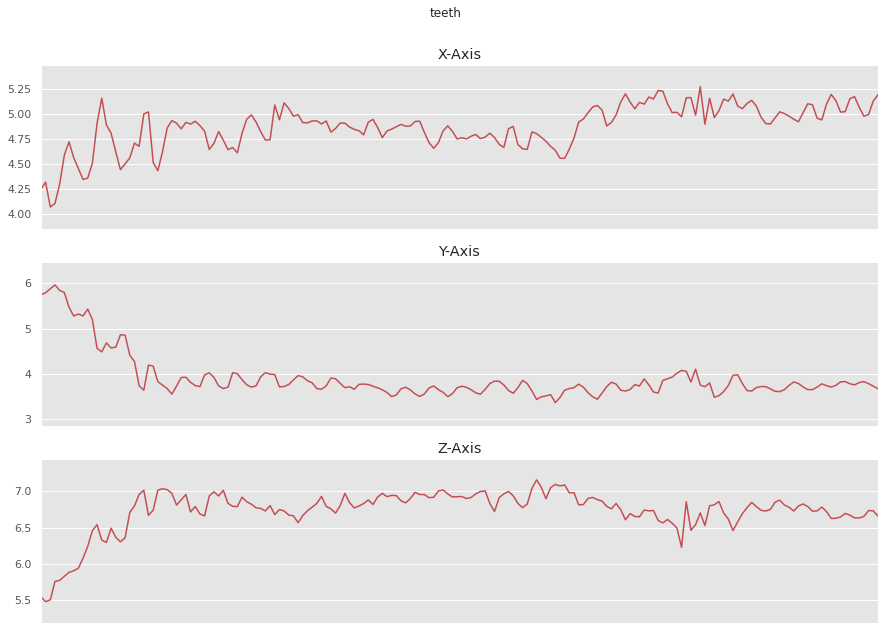

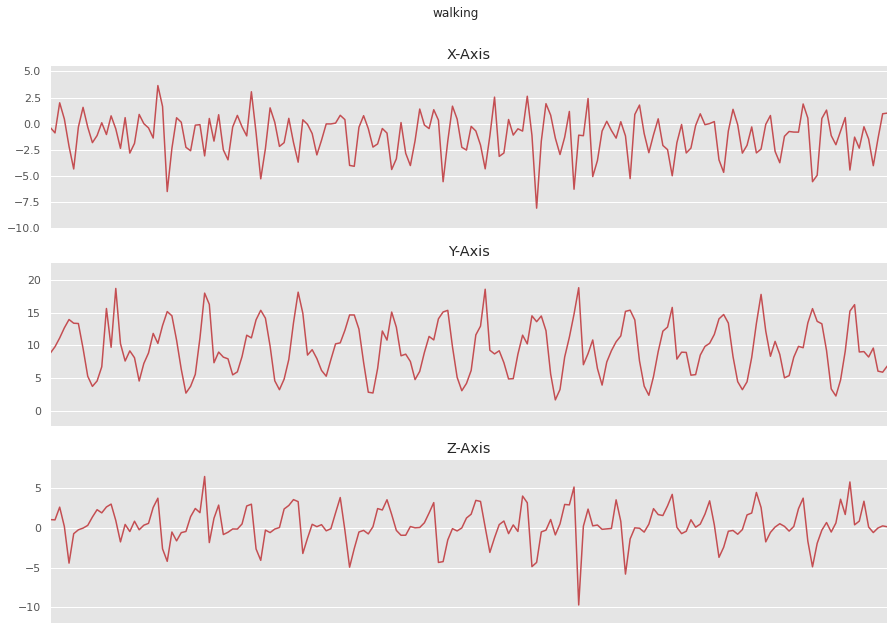

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
# # Separate based of user id.
# base_activity= ['A','C','E','G','I','K','M','P','R']


# df_base = df[  (df['activity']=='A') | (df['activity']=='C') | (df['activity']=='E')
#              | (df['activity']=='G') | (df['activity']=='I') | (df['activity']=='K')
#              | (df['activity']=='M') | (df['activity']=='P') | (df['activity']=='R')]
# le = labelenocoder(df_base)
# Separate based of user id.
base_activity= ['walking', 'stairs', 'standing', 'teeth', 'chips', 'drinking', 'kicking',  'dribbling',  'clapping']


df_base = df[  (df['activity']=='walking') | (df['activity']=='stairs') | (df['activity']=='standing')
             | (df['activity']=='teeth') | (df['activity']=='chips') | (df['activity']=='drinking')
             | (df['activity']=='kicking') | (df['activity']=='dribbling') | (df['activity']=='clapping')]
le = labelenocoder(df_base)

In [ ]:
LABEL = 'ActivityEncoded'
X_train,y_train = spliting_dataset(df_base)
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0,  stratify = y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2,  random_state = 0, stratify = y_train)
X_train = X_train.reshape(len(X_train), 80, 3, 1)
X_val = X_val.reshape(len(X_val), 80, 3, 1)
X_test = X_test.reshape(len(X_test), 80, 3, 1)
print('X_train: ',X_train.shape)
print('X_test: ',X_test.shape)
print('X_val shape', X_val.shape)

X_train Shape: (61018, 80, 3)
61018 training samples
y_train shape:  (61018,)
input_shape: 240
['chips', 'clapping', 'dribbling', 'drinking', 'kicking', 'stairs', 'standing', 'teeth', 'walking']
X_train:  (39051, 80, 3, 1)
X_test:  (12204, 80, 3, 1)
X_val shape (9763, 80, 3, 1)


In [ ]:
epochs = 50
model,history,duration = fit_model(X_train, y_train, X_val, y_val,learning_rate=0.001)

Epoch 1/50
1221/1221 [==============================] - 4s 4ms/step - loss: 1.3957 - accuracy: 0.4219 - val_loss: 1.1944 - val_accuracy: 0.5085
Epoch 2/50
1221/1221 [==============================] - 4s 3ms/step - loss: 1.1508 - accuracy: 0.5304 - val_loss: 1.0633 - val_accuracy: 0.5694
Epoch 3/50
1221/1221 [==============================] - 4s 3ms/step - loss: 1.0569 - accuracy: 0.5731 - val_loss: 0.9525 - val_accuracy: 0.6173
Epoch 4/50
1221/1221 [==============================] - 4s 4ms/step - loss: 0.9779 - accuracy: 0.6084 - val_loss: 0.9321 - val_accuracy: 0.6210
Epoch 5/50
1221/1221 [==============================] - 4s 3ms/step - loss: 0.9214 - accuracy: 0.6328 - val_loss: 0.8557 - val_accuracy: 0.6696
Epoch 6/50
1221/1221 [==============================] - 4s 4ms/step - loss: 0.8785 - accuracy: 0.6501 - val_loss: 0.8182 - val_accuracy: 0.6858
Epoch 7/50
1221/1221 [==============================] - 4s 4ms/step - loss: 0.8472 - accuracy: 0.6622 - val_loss: 0.7717 - val_accuracy:

In [ ]:
y_pred=model.predict_classes(X_test)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
print(con_mat_norm)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = base_activity, 
                     columns = base_activity)

[[0.82 0.03 0.   0.06 0.   0.   0.04 0.04 0.  ]
 [0.04 0.84 0.02 0.04 0.01 0.   0.04 0.02 0.  ]
 [0.   0.01 0.81 0.   0.1  0.05 0.01 0.   0.02]
 [0.09 0.03 0.   0.8  0.01 0.   0.02 0.04 0.  ]
 [0.   0.   0.11 0.   0.74 0.07 0.01 0.   0.05]
 [0.   0.   0.03 0.   0.07 0.8  0.   0.   0.09]
 [0.03 0.02 0.03 0.   0.02 0.   0.89 0.02 0.  ]
 [0.05 0.04 0.01 0.02 0.01 0.   0.02 0.84 0.  ]
 [0.   0.   0.01 0.   0.03 0.04 0.   0.   0.92]]


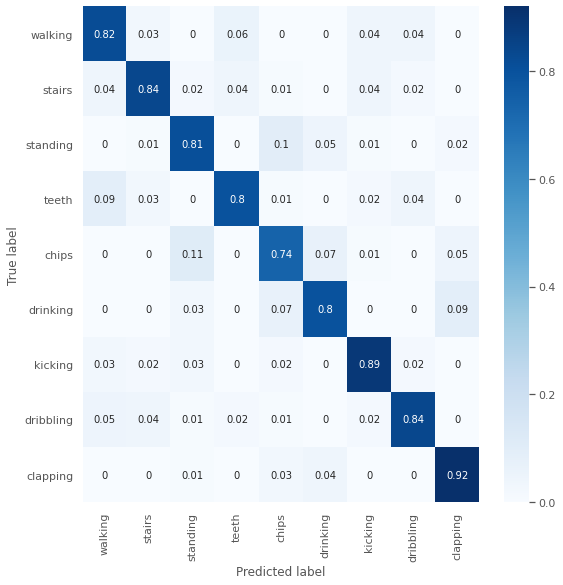

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
model.save('base_model_2.h5') 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


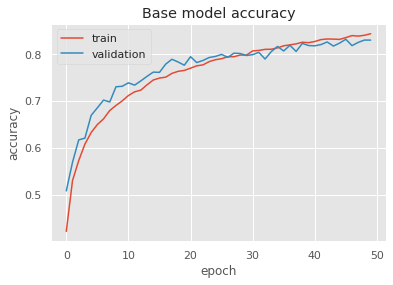

In [ ]:
print(history.history.keys())
fig = plt.figure()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['val_acc'])

plt.title('Base model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
fig.savefig('base_model_accuracy.png')
plt.show()

# Transfer Learning

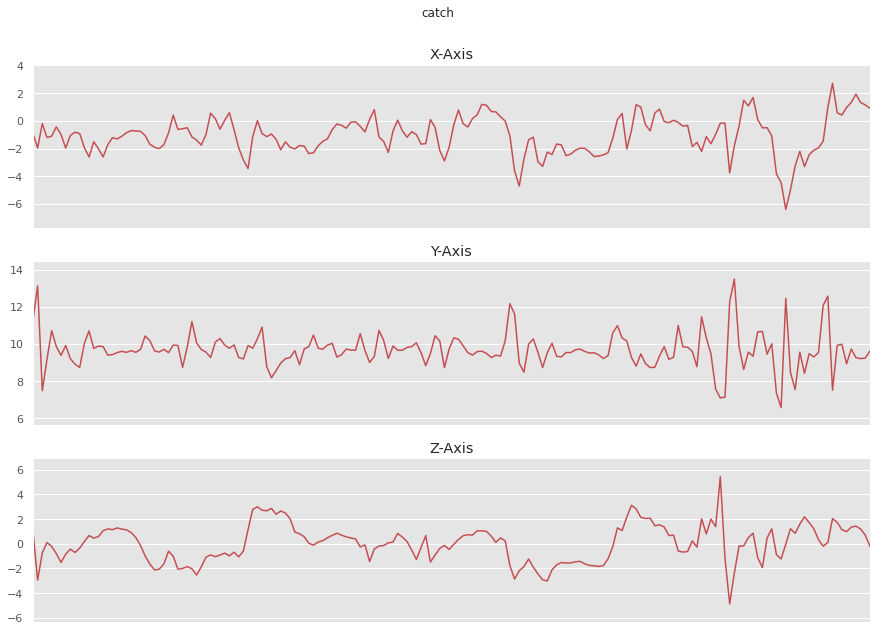

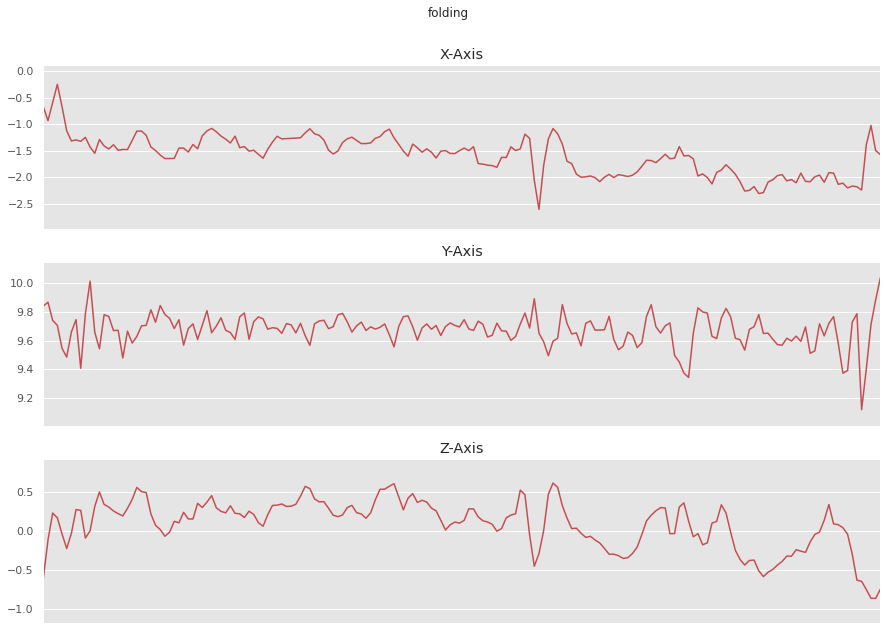

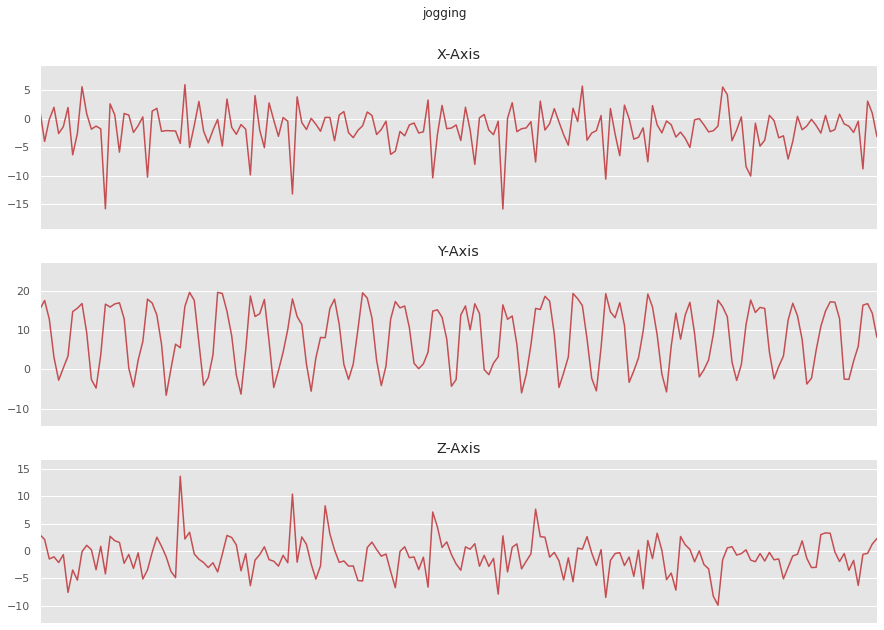

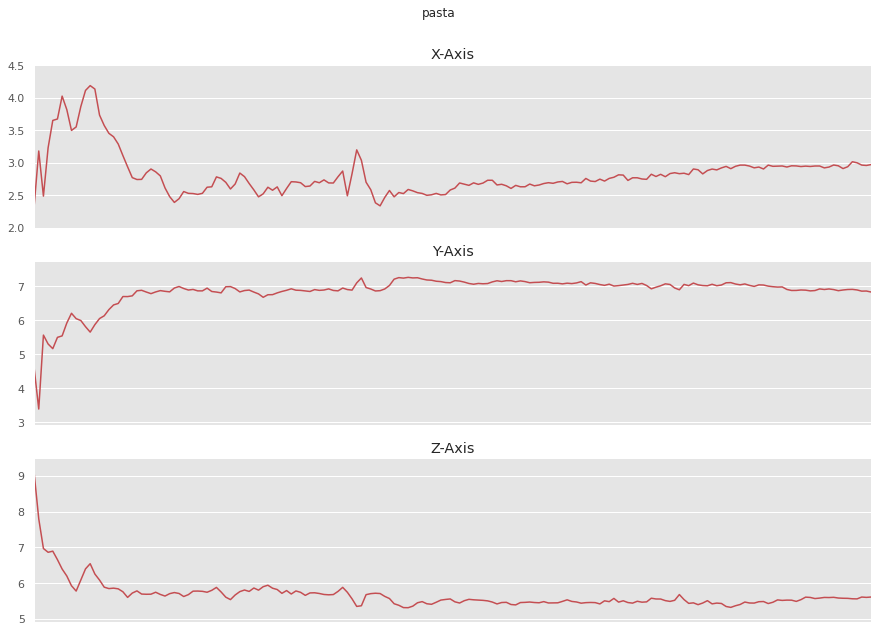

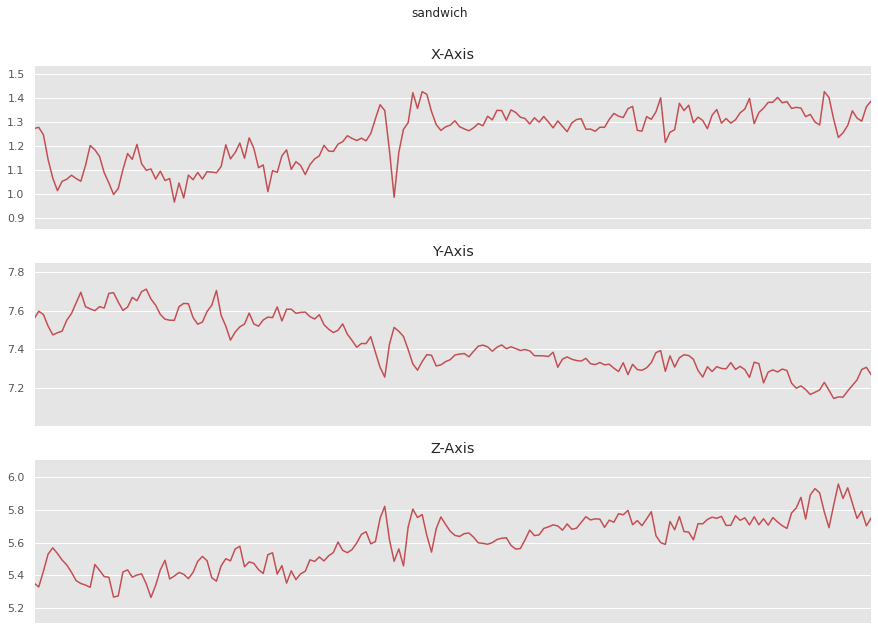

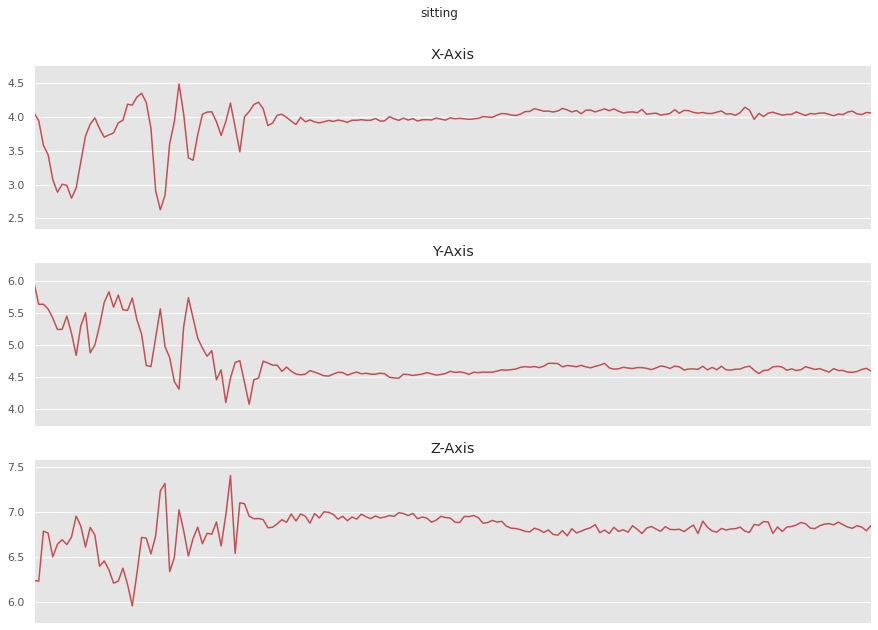

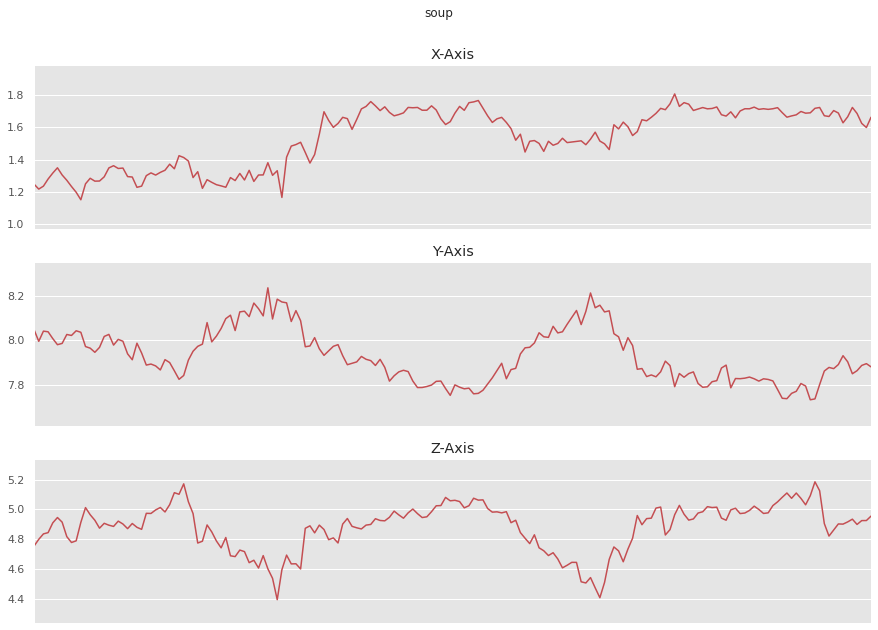

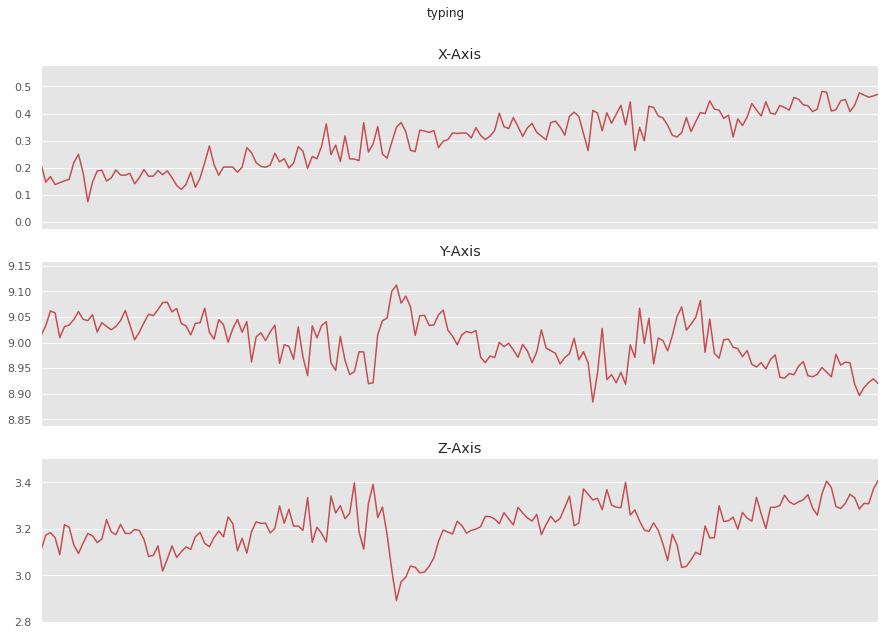

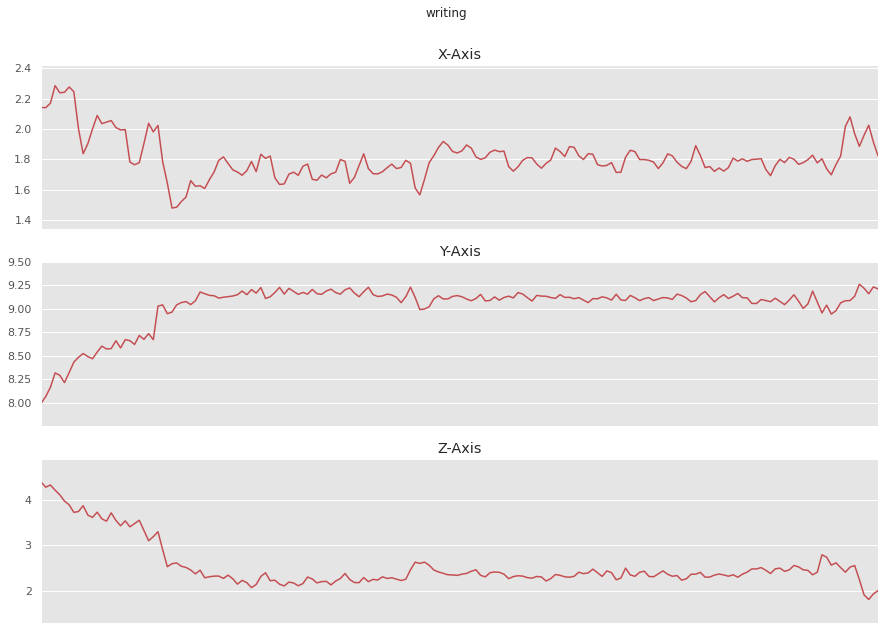

In [ ]:
# new_activity= ['B','D','F','H','J','L','O','Q','S']


# df_new = df[  (df['activity']=='B') | (df['activity']=='D') | (df['activity']=='F')
#              | (df['activity']=='H') | (df['activity']=='J') | (df['activity']=='L')
#              | (df['activity']=='O') | (df['activity']=='Q') | (df['activity']=='S')]
# le = labelenocoder(df_new)

new_activity= ['jogging','sitting','typing','soup','pasta','sandwich','catch','writing','folding']


df_new = df[  (df['activity']=='jogging') | (df['activity']=='sitting') | (df['activity']=='typing')
             | (df['activity']=='soup') | (df['activity']=='pasta') | (df['activity']=='sandwich')
             | (df['activity']=='catch') | (df['activity']=='writing') | (df['activity']=='folding')]
le = labelenocoder(df_new)

In [ ]:
X_train_new,y_train_new = spliting_dataset(df_new)

X_train Shape: (59089, 80, 3)
59089 training samples
y_train shape:  (59089,)
input_shape: 240


In [ ]:
num_time_periods, num_sensors = X_train_new.shape[1], X_train_new.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['catch', 'folding', 'jogging', 'pasta', 'sandwich', 'sitting', 'soup', 'typing', 'writing']


In [ ]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train_new, y_train_new, 
                                                                    test_size = 0.2, random_state = 0,  stratify = y_train_new)
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train_new, y_train_new, 
                                                                  test_size = 0.2,  random_state = 0, stratify = y_train_new)

In [ ]:
X_train_new.shape, X_test_new.shape
X_test_new.shape

(11818, 80, 3)

In [ ]:
X_train_new = X_train_new.reshape(len(X_train_new), 80, 3, 1)
X_val_new = X_val_new.reshape(len(X_val_new), 80, 3, 1)
X_test_new = X_test_new.reshape(len(X_test_new), 80, 3, 1)
print('X_train: ',X_train_new.shape)
print('X_test: ',X_test_new.shape)
print('X_val shape', X_val_new.shape)

X_train:  (37816, 80, 3, 1)
X_test:  (11818, 80, 3, 1)
X_val shape (9455, 80, 3, 1)


In [ ]:
n_repeats = 8
dists, dist_labels,durations = list(), list(),list()


In [ ]:
# ephos = 50
# standalone_scores, times = eval_standalone_model(X_train_new, X_test_new, y_train_new, y_test_new, X_val_new, y_val_new , n_repeats)
# print('Standalone %.3f (%.3f)' % (mean(standalone_scores), std(standalone_scores)))
# dists.append(standalone_scores)
# dist_labels.append('standalone')
# durations.append(times)
epochs = 50
model,history_fine,duration = fit_model(X_train, y_train, X_val, y_val,learning_rate=0.001)

Epoch 1/50
1221/1221 [==============================] - 5s 4ms/step - loss: 1.3969 - accuracy: 0.4186 - val_loss: 1.1425 - val_accuracy: 0.5357
Epoch 2/50
1221/1221 [==============================] - 4s 4ms/step - loss: 1.1438 - accuracy: 0.5339 - val_loss: 1.0106 - val_accuracy: 0.5964
Epoch 3/50
1221/1221 [==============================] - 4s 4ms/step - loss: 1.0442 - accuracy: 0.5799 - val_loss: 0.9748 - val_accuracy: 0.6020
Epoch 4/50
1221/1221 [==============================] - 4s 4ms/step - loss: 0.9844 - accuracy: 0.6082 - val_loss: 0.8886 - val_accuracy: 0.6506
Epoch 5/50
1221/1221 [==============================] - 4s 4ms/step - loss: 0.9321 - accuracy: 0.6306 - val_loss: 0.8631 - val_accuracy: 0.6624
Epoch 6/50
1221/1221 [==============================] - 4s 4ms/step - loss: 0.8955 - accuracy: 0.6450 - val_loss: 0.8494 - val_accuracy: 0.6791
Epoch 7/50
1221/1221 [==============================] - 4s 4ms/step - loss: 0.8543 - accuracy: 0.6629 - val_loss: 0.8201 - val_accuracy:

In [ ]:
y_pred_new=model.predict_classes(X_test_new)
con_mat = tf.math.confusion_matrix(labels=y_test_new, predictions=y_pred_new).numpy()

In [ ]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
print(con_mat_norm)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = new_activity, 
                     columns = new_activity)

[[0.05 0.08 0.42 0.05 0.17 0.05 0.16 0.02 0.01]
 [0.17 0.19 0.13 0.12 0.03 0.01 0.31 0.04 0.  ]
 [0.   0.05 0.15 0.   0.36 0.29 0.   0.   0.14]
 [0.28 0.09 0.01 0.44 0.   0.   0.14 0.04 0.  ]
 [0.36 0.15 0.03 0.26 0.02 0.01 0.12 0.06 0.  ]
 [0.25 0.14 0.01 0.49 0.01 0.   0.02 0.08 0.  ]
 [0.27 0.13 0.01 0.42 0.   0.   0.14 0.03 0.  ]
 [0.34 0.14 0.01 0.38 0.   0.   0.07 0.05 0.  ]
 [0.32 0.1  0.   0.44 0.   0.   0.1  0.02 0.  ]]


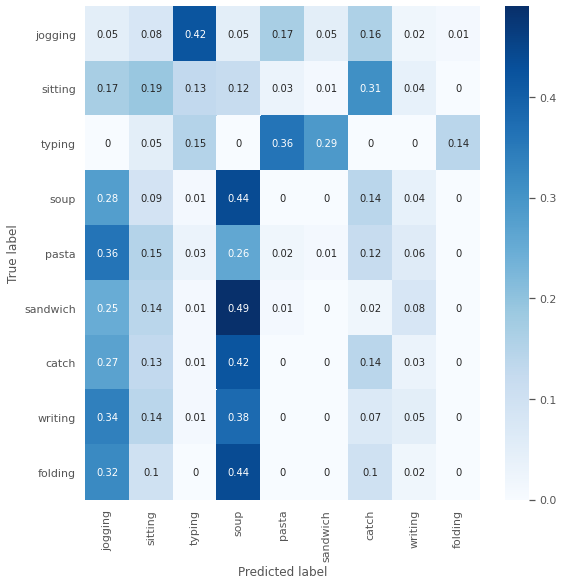

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


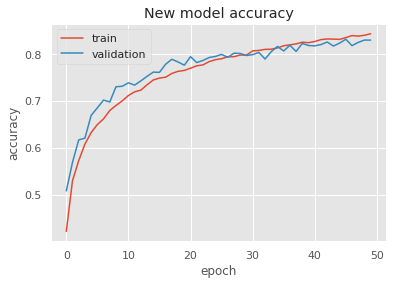

In [ ]:
print(history.history.keys())
fig = plt.figure()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['val_acc'])

plt.title('New model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
fig.savefig('new_model_accuracy.png')
plt.show()

In [ ]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
n_fixed = 8
n_repeats =3
for i in range(n_fixed):
    scores,times = eval_transfer_model(X_train_new,  X_test_new, y_train_new, y_test_new , i, n_repeats)
    print('Transfer (fixed=%d) %.3f (%.3f)' % (i, mean(scores), std(scores)))
    dists.append(scores)
    dist_labels.append('transfer f='+str(i))
    durations.append(times)
 
# box and whisker plot of score distributions


Transfer (fixed=0) 0.806 (0.006)
Transfer (fixed=1) 0.799 (0.005)
Transfer (fixed=2) 0.806 (0.014)
Transfer (fixed=3) 0.740 (0.010)
Transfer (fixed=4) 0.747 (0.010)
Transfer (fixed=5) 0.752 (0.004)
Transfer (fixed=6) 0.438 (0.007)
Transfer (fixed=7) 0.443 (0.003)


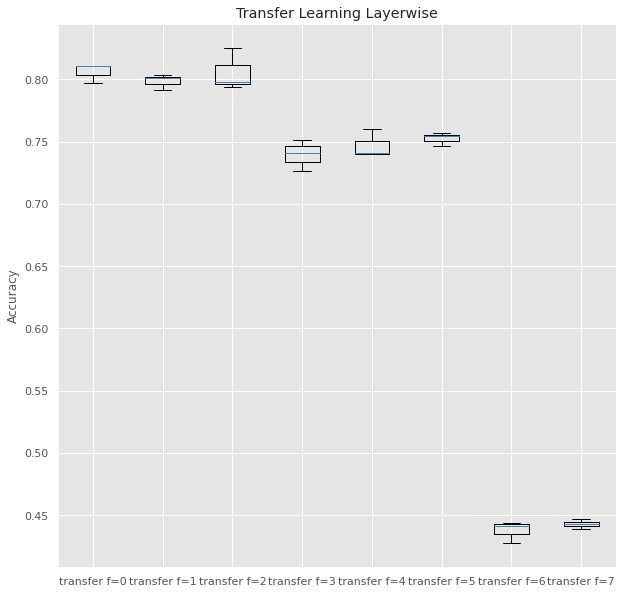

In [ ]:
fig = pyplot.figure(figsize=(10,10))
pyplot.title('Transfer Learning Layerwise')
plt.ylabel('Accuracy')
pyplot.boxplot(dists, labels=dist_labels)
fig.savefig('boxplot_tranferleraning.png')
pyplot.show()

In [ ]:
t = list()
for i in durations:
    t.append(float(mean(i)/60))

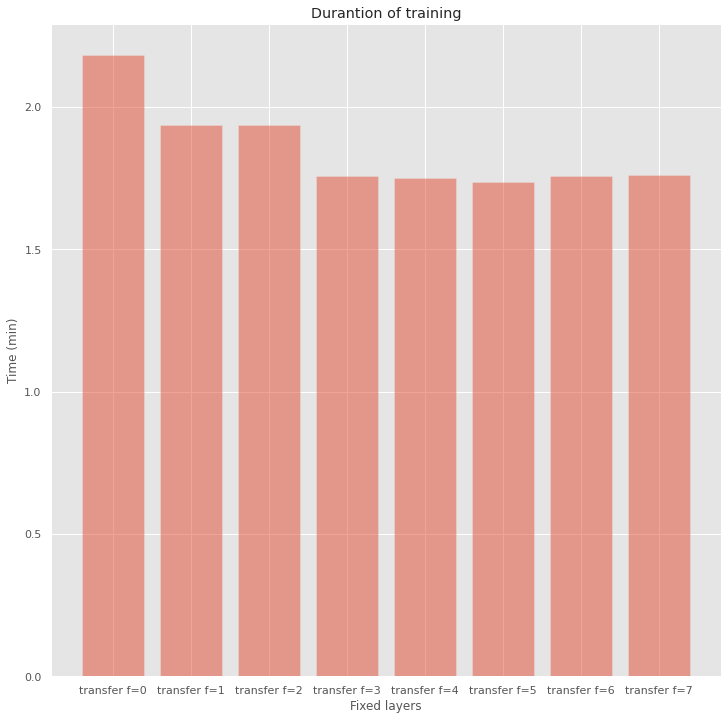

In [ ]:
fig = plt.figure(figsize=(12,12))
y_pos = np.arange(len(dist_labels))
plt.bar(y_pos, t, align='center', alpha=0.5)
plt.title('Durantion of training')
plt.ylabel('Time (min)')
plt.xticks(y_pos,dist_labels)
plt.xlabel('Fixed layers')
fig.savefig('duration_tranferlearning.png')
plt.show()

In [ ]:
print(scores)

[0.442629873752594, 0.44686073064804077, 0.4390759766101837]
